In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
import pandas as pd
import numpy as np
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization, ZeroPadding2D
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv('/content/gdrive/My Drive/ML J/preprocessedCIC.csv').sample(frac=1).reset_index(drop=True)[:200000]
df = df.replace([np.inf, -np.inf], np.nan).dropna()

In [4]:
df.shape

(199943, 39)

In [5]:
df["Label"].value_counts()

BENIGN                        170222
DoS Hulk                       15288
DDoS                           11393
DoS GoldenEye                    953
DoS slowloris                    468
DoS Slowhttptest                 457
FTP-Patator                      383
SSH-Patator                      295
PortScan                         159
Bot                              142
Web Attack  Brute Force         118
Web Attack  XSS                  58
Infiltration                       4
Web Attack  Sql Injection         2
Heartbleed                         1
Name: Label, dtype: int64

In [6]:
cl = len(df["Label"].value_counts())
cl

15

In [7]:
# Define the minority and majority classes
minority_class = ['Web Attack  Sql Injection', 'Infiltration', 'Web Attack  XSS']
majority_class = ['BENIGN', 'DoS Hulk', 'DDoS', 'PortScan', 'Web Attack  Brute Force', 'Bot', 'DoS Slowhttptest', 'DoS slowloris', 'FTP-Patator', 'SSH-Patator', 'DoS GoldenEye']

# Split the dataset into minority and majority
minority = df[df['Label'].isin(minority_class)].reset_index(drop=True)
majority = df[df['Label'].isin(majority_class)].reset_index(drop=True)

In [8]:
enn = NearestNeighbors(n_neighbors=500)
enn.fit(majority.drop(columns=['Label']))
difficult_idx = enn.kneighbors(minority.drop(columns=['Label']), return_distance=False).flatten()
difficult = df.iloc[difficult_idx]
easy = df.reset_index(drop=True).drop(difficult_idx)

In [9]:
difficult["Label"].value_counts()

BENIGN                      27275
DoS Hulk                     2357
DDoS                         1879
DoS GoldenEye                 158
DoS slowloris                  73
FTP-Patator                    64
SSH-Patator                    52
Web Attack  Brute Force       40
Bot                            37
DoS Slowhttptest               37
PortScan                       27
Web Attack  XSS                1
Name: Label, dtype: int64

In [10]:
easy["Label"].value_counts()

BENIGN                        163120
DoS Hulk                       14649
DDoS                           10928
DoS GoldenEye                    914
DoS slowloris                    449
DoS Slowhttptest                 443
FTP-Patator                      367
SSH-Patator                      284
PortScan                         153
Bot                              133
Web Attack  Brute Force         111
Web Attack  XSS                  57
Infiltration                       4
Web Attack  Sql Injection         2
Heartbleed                         1
Name: Label, dtype: int64

In [11]:
# Use KMeans to compress majority samples in the difficult set
kmeans = KMeans(n_clusters=100)
kmeans.fit(difficult.drop(columns=['Label']))
compressed = pd.DataFrame(kmeans.cluster_centers_, columns=difficult.columns[:-1])
compressed['Label'] = 'BENIGN'

In [12]:
# Generate synthetic minority samples in the difficult set
difficult_min = difficult[difficult['Label'].isin(minority_class)]
difficult_max = difficult[difficult['Label'] == 'BENIGN']
difficult_range = difficult_max - difficult_min
difficult_samples = pd.DataFrame()

In [48]:
for i in range(10):
  r = pd.DataFrame(columns=difficult_min.columns[:-1])
  random_values = np.random.rand(difficult_min.shape[1]-1)
  r.loc[0] = random_values
  dm = difficult_min.iloc[:,:-1]
  sample = dm.add(r, fill_value=0)
  sample['Label'] = minority_class[np.random.randint(0, len(minority_class))]
  difficult_samples = pd.concat([difficult_samples, sample], ignore_index=True)

In [14]:
new_train_set = pd.concat([easy, compressed, difficult_min, difficult_samples])
df2 = new_train_set.sample(frac=1).reset_index(drop=True)

In [15]:
df2

,Protocol,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Flow Bytes/s,Flow Packets/s,Fwd IAT Total,Bwd IAT Total,...,Avg Bwd Segment Size,Subflow Fwd Packets,Subflow Fwd Bytes,Subflow Bwd Packets,Subflow Bwd Bytes,Init_Win_bytes_forward,Init_Win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,Label
0,6.0,5962412.0,3.0,1.0,0.0,0.0,0.000000,0.670869,5962412.0,0.0,...,0.000000,3.0,0.0,1.0,0.0,29200.0,28960.0,0.0,32.0,Web Attack  Brute Force
1,6.0,98251805.0,7.0,6.0,327.0,11595.0,121.341282,0.132313,98200000.0,22408.0,...,1932.500000,7.0,327.0,6.0,11595.0,251.0,235.0,1.0,32.0,DoS Hulk
2,6.0,1856020.0,3.0,5.0,26.0,11607.0,6267.712632,4.310298,631.0,1855963.0,...,2321.400000,3.0,26.0,5.0,11607.0,8192.0,229.0,2.0,20.0,DDoS
3,6.0,100888628.0,9.0,6.0,1014.0,11595.0,124.979398,0.148679,101000000.0,559418.0,...,1932.500000,9.0,1014.0,6.0,11595.0,274.0,235.0,3.0,32.0,DoS Hulk
4,6.0,61775824.0,15.0,13.0,909.0,3504.0,71.435712,0.453252,61775824.0,61691798.0,...,269.538462,15.0,909.0,13.0,3504.0,29200.0,123.0,3.0,32.0,BENIGN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
191731,6.0,116223944.0,20.0,18.0,973.0,4530.0,47.348247,0.326955,116000000.0,111000000.0,...,251.666667,20.0,973.0,18.0,4530.0,8192.0,980.0,19.0,20.0,BENIGN
191732,6.0,98730684.0,8.0,6.0,382.0,11595.0,121.309805,0.141800,98600000.0,148472.0,...,1932.500000,8.0,382.0,6.0,11595.0,274.0,235.0,1.0,32.0,DoS Hulk
191733,17.0,154.0,2.0,2.0,46.0,46.0,597402.597400,25974.025970,3.0,2.0,...,23.000000,2.0,46.0,2.0,46.0,-1.0,-1.0,1.0,32.0,BENIGN
191734,17.0,26918.0,4.0,4.0,176.0,400.0,21398.320830,297.198900,26764.0,3034.0,...,100.000000,4.0,176.0,4.0,400.0,-1.0,-1.0,3.0,20.0,BENIGN


In [16]:
df2["Label"].value_counts()

BENIGN                        163220
DoS Hulk                       14649
DDoS                           10928
DoS GoldenEye                    914
DoS slowloris                    449
DoS Slowhttptest                 443
FTP-Patator                      367
SSH-Patator                      284
PortScan                         153
Bot                              133
Web Attack  Brute Force         111
Web Attack  XSS                  68
Web Attack  Sql Injection         8
Infiltration                       8
Heartbleed                         1
Name: Label, dtype: int64

In [17]:
X_train, X_test, y_train, y_test = train_test_split(df2.iloc[:,:-1], df2.iloc[:,-1], test_size=0.3, random_state=42)

In [18]:
to_remove = [x for x in y_test.unique() if x not in y_train.unique()]
rows_to_remove = y_test.isin(to_remove)

y_test = y_test[~rows_to_remove]
X_test = X_test[~rows_to_remove]

In [19]:
X_train.shape

(134215, 38)

In [20]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train1 = X_train
X_test1 = X_test

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [21]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

In [22]:
unique_labels = le.transform(df2['Label'].unique())

In [23]:
# Convert the training and testing data into DMatrix format
dtrain = xgb.DMatrix(X_train, label=y_train_encoded)
dtest = xgb.DMatrix(X_test, label=y_test_encoded)

param = {'max_depth': 10, 'eta': 1}
num_round = 10
bst = xgb.train(param, dtrain, num_round)

y_pred = bst.predict(dtest)
y_pred = np.round(y_pred).astype(int)

accuracy = accuracy_score(y_test_encoded, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 98.96%


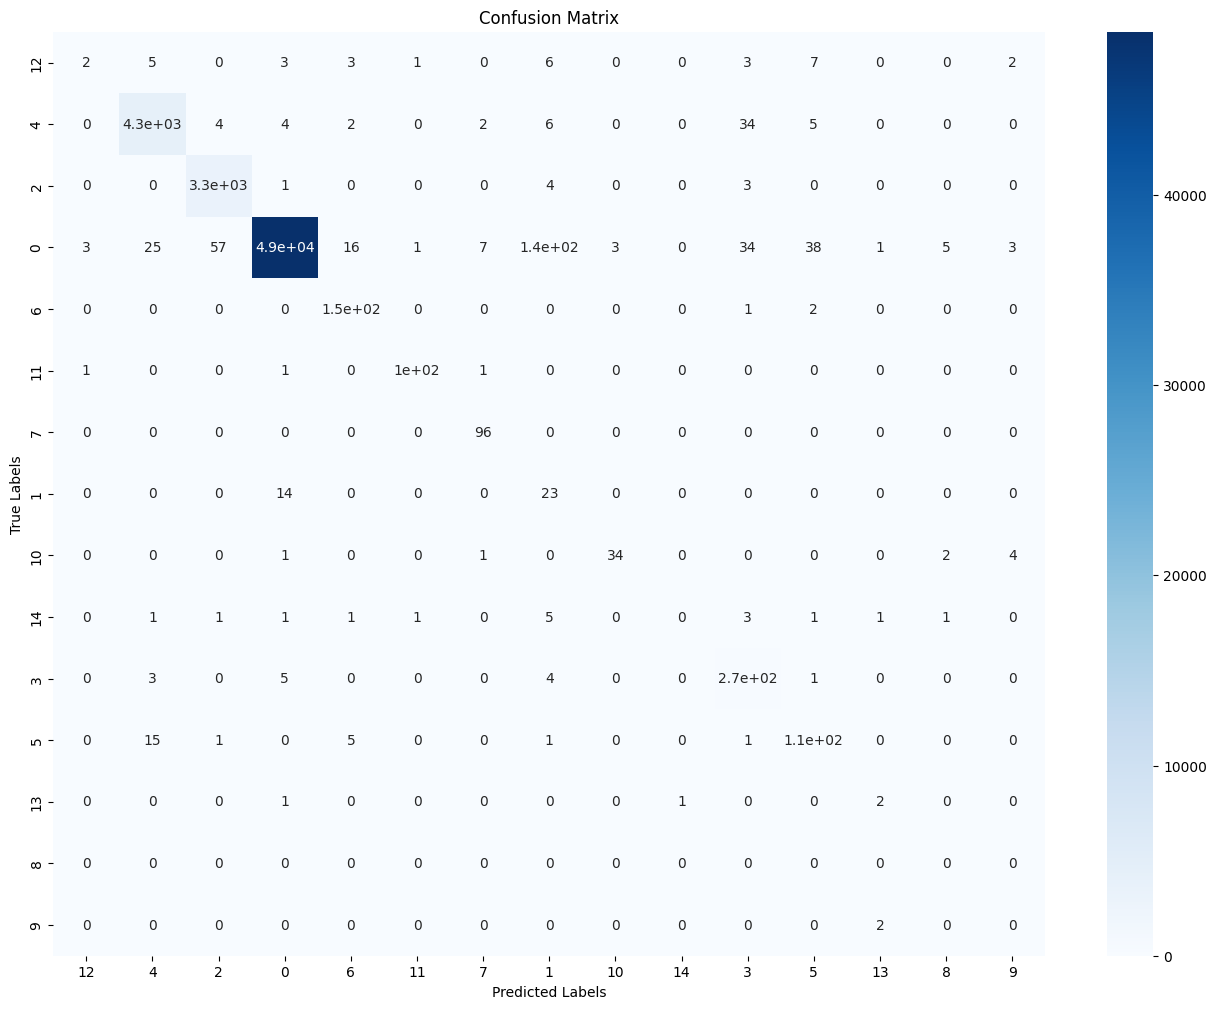

In [24]:
cm = confusion_matrix(y_test_encoded, y_pred, labels=unique_labels)
fig, ax = plt.subplots(figsize=(16, 12))
sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=unique_labels, yticklabels=unique_labels)

plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")

plt.show()

In [25]:
X1_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X1_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

#LSTM
model = Sequential()
model.add(LSTM(128, input_shape=(X1_train.shape[1], X1_train.shape[2]), activation='tanh', return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64, activation='tanh'))
model.add(Dropout(0.2))
model.add(Dense(32, activation='LeakyReLU'))
model.add(Dropout(0.2))
model.add(Dense(cl, activation='softmax'))

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.fit(X1_train, y_train_encoded, epochs=10, validation_data=(X1_test, y_test_encoded))

results = model.evaluate(X1_test,y_test_encoded)
print("\n\nAccuracy: %.2f%%" % (results[1]*100))

Epoch 1/10
4195/4195 [==============================] - 45s 9ms/step - loss: 0.1707 - accuracy: 0.9598 - val_loss: 0.0796 - val_accuracy: 0.9787
Epoch 2/10
4195/4195 [==============================] - 45s 11ms/step - loss: 0.0811 - accuracy: 0.9784 - val_loss: 0.0582 - val_accuracy: 0.9850
Epoch 3/10
4195/4195 [==============================] - 48s 11ms/step - loss: 0.0673 - accuracy: 0.9818 - val_loss: 0.0548 - val_accuracy: 0.9836
Epoch 4/10
4195/4195 [==============================] - 43s 10ms/step - loss: 0.0591 - accuracy: 0.9838 - val_loss: 0.0532 - val_accuracy: 0.9845
Epoch 5/10
4195/4195 [==============================] - 38s 9ms/step - loss: 0.0544 - accuracy: 0.9848 - val_loss: 0.0480 - val_accuracy: 0.9861
Epoch 6/10
4195/4195 [==============================] - 40s 10ms/step - loss: 0.0513 - accuracy: 0.9855 - val_loss: 0.0442 - val_accuracy: 0.9853
Epoch 7/10
4195/4195 [==============================] - 37s 9ms/step - loss: 0.0489 - accuracy: 0.9863 - val_loss: 0.0382 - va

1798/1798 [==============================] - 8s 4ms/step


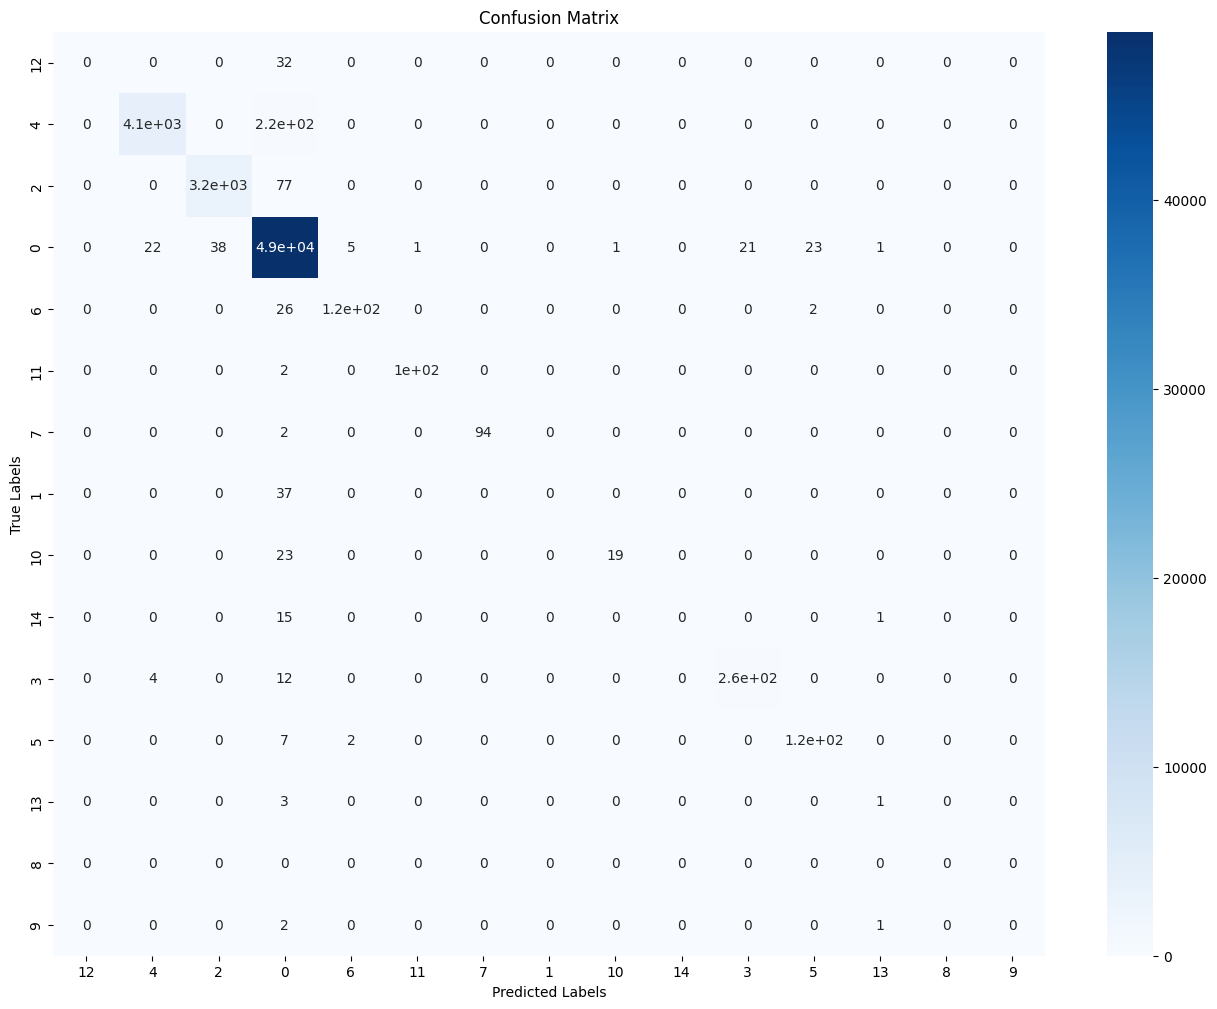

In [42]:
y_pred = np.argmax(model.predict(X1_test), axis=-1)

cm = confusion_matrix(y_test_encoded, y_pred, labels=unique_labels)
fig, ax = plt.subplots(figsize=(16, 12))
sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=unique_labels, yticklabels=unique_labels)

plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")

plt.show()

In [43]:
X2_train = X_train.reshape((X_train.shape[0], 19, 2, 1))
X2_test = X_test.reshape((X_test.shape[0], 19, 2, 1))

# MINI-VGGNet model
model = Sequential()
model.add(Conv2D(32, (2, 1), activation='relu', input_shape=(19, 2, 1)))
model.add(Conv2D(32, (2, 1), activation='relu'))
model.add(MaxPooling2D((2, 1)))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(cl, activation='softmax'))


model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.fit(X2_train, y_train_encoded, epochs=10, validation_data=(X2_test, y_test_encoded))

results = model.evaluate(X2_test,y_test_encoded)
print("\n\nAccuracy: %.2f%%" % (results[1]*100))

Epoch 1/10
4195/4195 [==============================] - 27s 6ms/step - loss: 0.1277 - accuracy: 0.9698 - val_loss: 0.0714 - val_accuracy: 0.9838
Epoch 2/10
4195/4195 [==============================] - 23s 5ms/step - loss: 0.0630 - accuracy: 0.9834 - val_loss: 0.0515 - val_accuracy: 0.9869
Epoch 3/10
4195/4195 [==============================] - 25s 6ms/step - loss: 0.0527 - accuracy: 0.9853 - val_loss: 0.0542 - val_accuracy: 0.9857
Epoch 4/10
4195/4195 [==============================] - 24s 6ms/step - loss: 0.0461 - accuracy: 0.9865 - val_loss: 0.0545 - val_accuracy: 0.9838
Epoch 5/10
4195/4195 [==============================] - 23s 6ms/step - loss: 0.0428 - accuracy: 0.9873 - val_loss: 0.0428 - val_accuracy: 0.9892
Epoch 6/10
4195/4195 [==============================] - 22s 5ms/step - loss: 0.0403 - accuracy: 0.9879 - val_loss: 0.0370 - val_accuracy: 0.9891
Epoch 7/10
4195/4195 [==============================] - 25s 6ms/step - loss: 0.0388 - accuracy: 0.9883 - val_loss: 0.0358 - val_ac

1798/1798 [==============================] - 5s 3ms/step


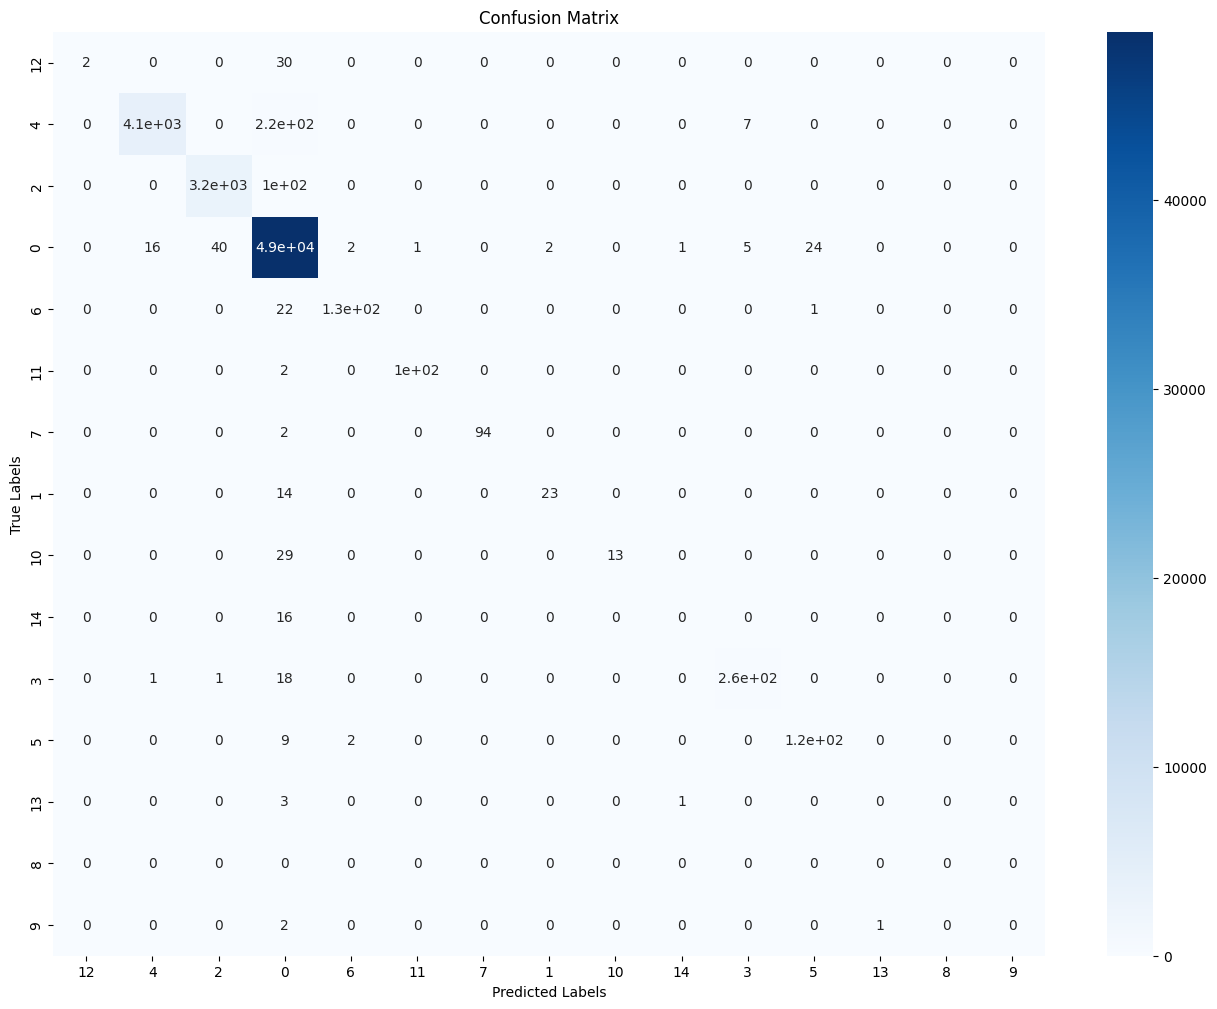

In [45]:
y_pred = np.argmax(model.predict(X2_test), axis=-1)

cm = confusion_matrix(y_test_encoded, y_pred, labels=unique_labels)
fig, ax = plt.subplots(figsize=(16, 12))
sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=unique_labels, yticklabels=unique_labels)

plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")

plt.show()

In [46]:
# Define the AlexNet model
model = Sequential()
model.add(Conv2D(filters=96, kernel_size=(2,1), strides=(4,4), activation='relu', input_shape=(19, 2, 1)))
model.add(MaxPooling2D(pool_size=(2,1), strides=(2,2)))
model.add(BatchNormalization())
model.add(Conv2D(filters=256, kernel_size=(2,1), strides=(1,1), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,1), strides=(2,2)))
model.add(BatchNormalization())
model.add(Conv2D(filters=384, kernel_size=(2,1), strides=(1,1), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters=384, kernel_size=(2,1), strides=(1,1), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters=256, kernel_size=(2,1), strides=(1,1), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(1,1), strides=(1,1)))
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dense(4096, activation='relu'))
model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(Dense(4096, activation='relu'))
model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(Dense(cl, activation='softmax'))

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.fit(X2_train, y_train_encoded, epochs=2, validation_data=(X2_test, y_test_encoded))

results = model.evaluate(X2_test,y_test_encoded)
print("\n\nAccuracy: %.2f%%" % (results[1]*100))

Epoch 1/2
4195/4195 [==============================] - 1764s 419ms/step - loss: 0.4385 - accuracy: 0.8796 - val_loss: 0.5557 - val_accuracy: 0.8479
Epoch 2/2
1798/1798 [==============================] - 80s 45ms/step - loss: 0.8007 - accuracy: 0.9036


Accuracy: 90.36%


1798/1798 [==============================] - 80s 44ms/step


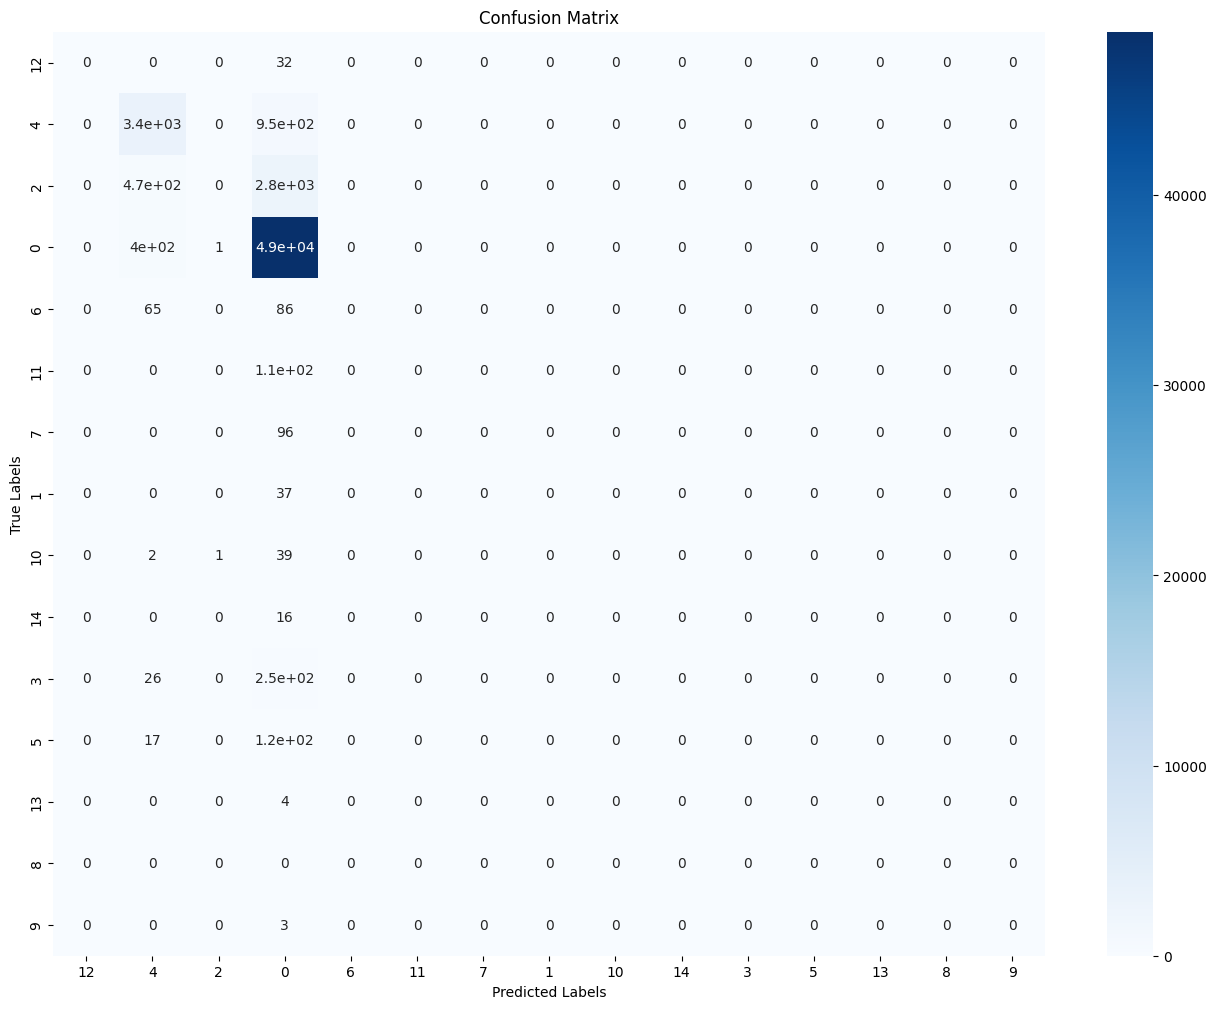

In [47]:
y_pred = np.argmax(model.predict(X2_test), axis=-1)

cm = confusion_matrix(y_test_encoded, y_pred, labels=unique_labels)
fig, ax = plt.subplots(figsize=(16, 12))
sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=unique_labels, yticklabels=unique_labels)

plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")

plt.show()